# Dataset

For this project we are using the dataset ESC-50 (available on [Github](https://github.com/karolpiczak/ESC-50)). ESC-50 is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification. The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories: animals, natural soundscapes & water sounds, human non-speech sounds, interior/domestic sounds, and exterior/urban noises. If you would like to know more details, be sure to check out the [original paper](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) by K. Piczak.

The version of the dataset I am using is from [Kaggle](https://www.kaggle.com/datasets/mmoreaux/environmental-sound-classification-50), which is essentially the same as the original, except the audio files have been processed through the `to_wav.py` script present in the original repository to transform them from OGG to WAV. The Kaggle dataset consists of 50 WAV files sampled at 16KHz/44.1KHz for 50 different classes, and for each one of the classes, there are 40 corresponding audio samples of 5 seconds each. All of the audio files have been concatenated by class in order to have 50 wave files of 200 seconds (3 mins 20 secs).

Now that we have an understanding of the dataset, let's get started by unzipping the dataset to a folder `esc50_data` and checking out the metadata file.

In [1]:
# %%capture
# !unzip archive.zip -d esc50_data

In [2]:
import pandas as pd

esc50_metadata = pd.read_csv("esc50_data/esc50.csv")

esc50_metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


The columns in the metadata give us the following information:
* `filename`: WAV file path
* `fold`: Index of the cross-validation fold [1, 5]
* `target`: Class in numeric format [0, 49]
* `category`: Class in text format
* `esc10`: Indicates if a given file belongs to the ESC-10 subset (10 selected classes)
* `src_file`: ID of original sound file
* `take`: Letter disambiguating between different fragments from the same Freesound clip

# Viz Data Generation

The class `ESC50` included in the `utils.py` helper script that comes with the dataset provides an easy way to access the data as 16000 or 44100KHz raw waves.

`ESC50` allows us to access the data with any desired augmentations like so:

    ESC50(only_ESC10, folds, randomize, audio_rate, strongAugment, pad, inputLength, random_crop, mix, normalize)

The class also comes with 2 handy generators:
* `_data_gen` to retrieve audio samples one at a time, and
* `batch_gen(batch_size)` to retrieve batches of audio samples (calls the former).

ESC-50 is arranged into 5 uniformly sized cross-validation folds, ensuring that clips originating from the same initial source file are always contained in a single fold. In this section, we divide the data into training and test sets, with folds 1, 2, 3 4 used for training and fold 5 used for testing.

For the train data we introduce noise by applying augmentations like random scaling and crops to make the model more robust. The test data is kept as-is since we ultimately want the model to perform well on un-augmented data points.

**For the sake of simplicity, I will be using ESC-10 for the rest of this project.** ESC-10 is a selection of 10 classes from the bigger
dataset for proof-of-concept purposes. All code here is compatible with ESC50, you will just need to tweak a few hyperparameters to make the model fit the full dataset.

In [3]:
print("Number of audio clips in ESC-10 =", esc50_metadata[esc50_metadata["esc10"]==True].shape[0])

Number of audio clips in ESC-10 = 400


In [4]:
# adds data directory to python path 
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.insert(1, "esc50_data")
from utils import ESC50

train_split = [1,2,3,4]
test_split = [5]

shared_params = {
    'csv_path': 'esc50_data/esc50.csv',  # path of the CSV file
    'wav_dir': 'esc50_data/audio/audio',  # path of the wav files
    'dest_dir': 'esc50_data/audio/audio/16000',  # directory where the sub-sampled wav are stored
    'audio_rate': 16000,  # audio rate of samples
    'only_ESC10': True,  # whether to use ESC10 instead of ESC50
    'normalize': False  # does not normalize input (done later during mfcc)
}

viz_batch_gen = ESC50(
    folds=[1,2,3,4,5], # the folds to load from (1,2,3,4)
    randomize=True,  # randomize samples
    strongAugment=True,  # random scale and put gain in audio input 
    random_crop=True,  # performs random crops
    inputLength=2,  # time in seconds of the audio input
    pad=0,  # adds padding before and after audio signal
    mix=True,  # whether to mix samples or not (between classes learning)
    **shared_params
).batch_gen(16)  # batch size 16

In [5]:
X_sample, y_sample = next(viz_batch_gen)  # gets one batch of 16 samples from train set
X_sample.shape, y_sample.shape

((16, 32000, 1), (16, 10))

> (16, 32000, 1): 16 batch size, 32000 = 16000Hz * 2 secs)

> (16, 10): 16 batch size, 10 classes (sometimes sound of multiple label types are in the same clip, but we will use the argmax)

Great, with this we have been able to create data generator and get a sample batch! The next step is to get a human-readable version of the labels to help interpretability.

In [6]:
esc50_classes = esc50_metadata[['target', 'category']].values.tolist()
esc50_classes = set(['{} {}'.format(c[0], c[1]) for c in esc50_classes])
esc50_classes = np.array([c.split(' ') for c in esc50_classes])
esc50_classes = {k: v for k, v in esc50_classes}; esc50_classes

{'20': 'crying_baby',
 '10': 'rain',
 '45': 'train',
 '28': 'snoring',
 '33': 'door_wood_creaks',
 '1': 'rooster',
 '2': 'pig',
 '22': 'clapping',
 '23': 'breathing',
 '14': 'chirping_birds',
 '42': 'siren',
 '48': 'fireworks',
 '46': 'church_bells',
 '18': 'toilet_flush',
 '44': 'engine',
 '39': 'glass_breaking',
 '16': 'wind',
 '12': 'crackling_fire',
 '25': 'footsteps',
 '29': 'drinking_sipping',
 '30': 'door_wood_knock',
 '19': 'thunderstorm',
 '27': 'brushing_teeth',
 '37': 'clock_alarm',
 '35': 'washing_machine',
 '36': 'vacuum_cleaner',
 '26': 'laughing',
 '41': 'chainsaw',
 '31': 'mouse_click',
 '17': 'pouring_water',
 '21': 'sneezing',
 '0': 'dog',
 '43': 'car_horn',
 '15': 'water_drops',
 '6': 'hen',
 '5': 'cat',
 '13': 'crickets',
 '38': 'clock_tick',
 '34': 'can_opening',
 '47': 'airplane',
 '7': 'insects',
 '8': 'sheep',
 '4': 'frog',
 '11': 'sea_waves',
 '9': 'crow',
 '40': 'helicopter',
 '49': 'hand_saw',
 '3': 'cow',
 '32': 'keyboard_typing',
 '24': 'coughing'}

Here we can see all the 50 classes in ESC50, but remember that we will only be using 10 of these. So we can filter it further down to the classes in ESC-10 (the variable `lbl_indexes` in `utils.py` is where I'm getting the indexes of these classes from):

In [7]:
esc10_classes = [esc50_classes[str(x)] for x  in [0, 1, 10, 11, 12, 20, 21, 38, 40, 41]]; esc10_classes

['dog',
 'rooster',
 'rain',
 'sea_waves',
 'crackling_fire',
 'crying_baby',
 'sneezing',
 'clock_tick',
 'helicopter',
 'chainsaw']

# Visualization
We can now compute the spectrograms for the batch of audio samples and plot them next to their raw waves.

Note: Some of the audio clips might sound warped due to augmentations. Keep in mind that some clips have multiple classes present in them, and the 2 second clipping can make the label seem confusing (e.g. if the clip is predominantly of rooster noises along with some baby noises but by coincidence the 2 second clip only captures the part with baby noises).

> For this section, I have modified the code available [here](https://www.kaggle.com/code/mmoreaux/esc50-visualization/notebook). Thanks to the author Marc Moreaux for his great work.

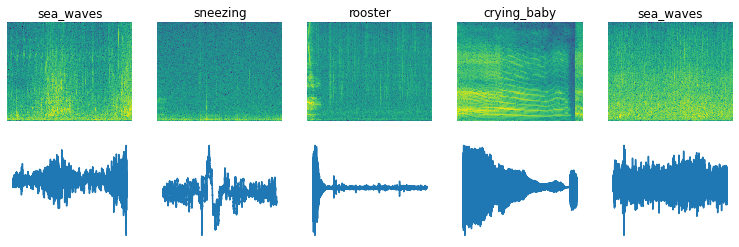

In [8]:
import scipy
from scipy import signal
import IPython.display as ipd

fig, axs = plt.subplots(2, 5, figsize=(13, 4))

for idx in range(5):
    i, j = int(idx / 5), int(idx % 5)
    x = X_sample[idx]
    sampleFreqs, segmentTimes, sxx = signal.spectrogram(x[:, 0], 16000)
    axs[i*2][j].pcolormesh(
        (len(segmentTimes) * segmentTimes / segmentTimes[-1]),
        sampleFreqs,
        10 * np.log10(sxx + 1e-15)
    )
    axs[i*2][j].set_title(esc10_classes[np.argmax(y_sample[idx])])
    axs[i*2][j].set_axis_off()
    axs[i*2+1][j].plot(x)
    axs[i*2+1][j].set_axis_off()
    
plt.show()

# listen to the audio samples
for idx in range(5):
    x = X_sample[idx]
    ipd.display(ipd.Audio(x[:, 0], rate=16000))

# Train/Test Set Initialization

By applying the ideas discussed above, we can now generate a train/test set!

We will be utilizing the library `librosa` to get the mel-spectrograms of the signals. The mel-spectrogram is a concise "snapshot" of an audio wave, and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images. Some approaches use the Mel-Frequency Cepstral Coefficients (MFCC) of the signals instead, but MFCC is a very compressible representation, usually using just 20 or 13 coefficients instead of the 32-64 bands in mel-spectrograms. This means with lots of data and strong classifiers like CNNs, mel-spectrograms often perform better.

> Note: The spectrograms that were shown above are **not** mel-spectrograms.

In [9]:
%%capture
!pip install librosa

In [10]:
import librosa
import numpy as np

train_len = len(esc50_metadata[(esc50_metadata["esc10"]==True) & ~(esc50_metadata["fold"]==test_split[0])])

train_gen = ESC50(folds=train_split,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=4,
                  mix=True,
                  **shared_params).batch_gen(train_len)

X_train = []
y_train = []

signals, labels = next(train_gen)

for signal, label in zip(signals, labels):
    signal = signal.flatten()  # flattens signal (same as x[:, 0])
    label = esc10_classes[np.argmax(label)]  # gets label
    sgram = librosa.stft(signal)  # short time fourier transform
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=16000)  # gets mel-spectrogram
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)  # uses the decibel scale to get the final Mel Spectrogram
    X_train.append(mel_sgram)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)

### A Short Note on the Decibel Scale

You might notice in the code above that after we get the mel-spectrograms there is an additional processing step that converts them to the decibel scale. The reason for this is that mel-spectrograms on the amplitude scale are generally dark and don't carry enough useful information. Check out these images that clearly demonstrate the difference.

Amplitude Scale             |  Decibel Scale
:-------------------------:|:-------------------------:
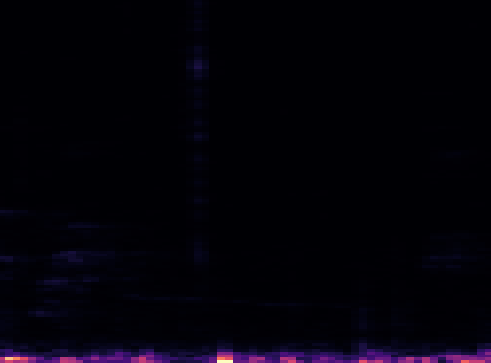  |  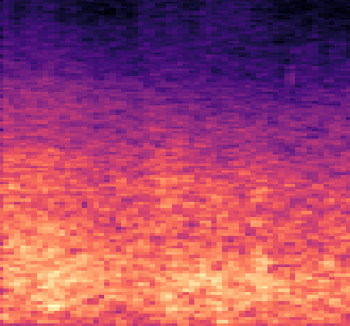

In [11]:
test_len = len(esc50_metadata[(esc50_metadata["esc10"]==True) & (esc50_metadata["fold"]==test_split[0])])

test_gen = ESC50(folds=test_split,
                 randomize=False,
                 strongAugment=False,
                 random_crop=False,
                 inputLength=4,
                 mix=False,
                 **shared_params).batch_gen(test_len)

X_test = []
y_test = []

signals, labels = next(test_gen)

for signal, label in zip(signals, labels):
    signal = signal.flatten()  # flattens signal (same as x[:, 0])
    label = esc10_classes[np.argmax(label)]  # gets label
    sgram = librosa.stft(signal)  # short time fourier transform
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=16000)  # gets mel-spectrogram
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)  # uses the decibel scale to get the final Mel Spectrogram
    X_test.append(mel_sgram)
    y_test.append(label)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

Information of the variables shapes is necessary to set the input shape for first layer of neural network, so let's take a look.

In [12]:
X_train.shape

(320, 128, 126)

In [13]:
X_test.shape

(80, 128, 157)

We have a small problem here - the dimensions of the graphs in the train and test sets are slightly different. Let's inspect the graphs to see if we can use any padding or truncation tips to fix this.

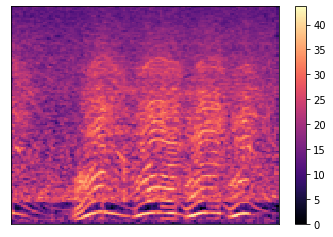

In [14]:
import librosa.display

plt.figure()
librosa.display.specshow(X_train[10])
plt.colorbar()

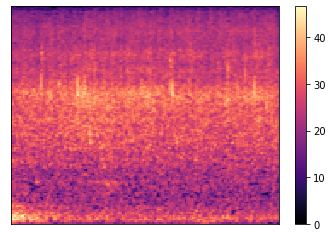

In [15]:
plt.figure()
librosa.display.specshow(X_test[10])
plt.colorbar()

...looks like there should be no problem simply padding the train set spectrograms!

In [16]:
X_train = np.pad(X_train, ((0, 0), (0, 0), (0, 31)), "constant")

In [17]:
X_train.shape

(320, 128, 157)

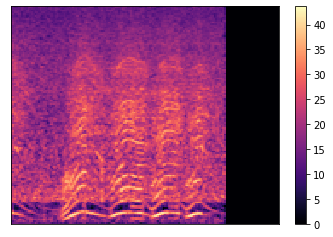

In [18]:
plt.figure()
librosa.display.specshow(X_train[10])
plt.colorbar()

There's one last challenge that needs to be overcome before the data is ready to be fed to a model. In general, CNNs take input as (no_of_samples, height, width, channels), but our X has the dimensions (no_of_samples, height, width). To fix this issue, we simply need to add dimensions in a way that no data is lost.

In [19]:
# The below code will reshape the data to (no_of_samples, height, width, 1).
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [20]:
X_train.shape

(320, 128, 157, 1)

In [21]:
X_test.shape

(80, 128, 157, 1)

Looks like we are all set! The last step before we can feed the data to a model is to encode the target.

In [22]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1,1)).todense()
y_test_enc = enc.transform(y_test.reshape(-1,1)).todense()

# Model Building

CNNs are widely considered state-of-the-art for audio classification tasks, and as such I will be implementing a basic CNN architecture in `keras` for this dataset.

In [23]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    #first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 157, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    #second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
]) 

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="acc")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 155, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 77, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 35, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 17, 64)       0

In [25]:
%%capture
%mkdir "cnn_logs"
%mkdir "cnn_ckpt"

In [28]:
from tensorflow.keras import callbacks

LOGDIR = "cnn_logs"
CKPT = "cnn_ckpt"

# saves best model checkpoint
ckpt_callback = callbacks.ModelCheckpoint(
    CKPT, monitor="val_loss", verbose=0, save_best_only=True,
    save_weights_only=True, mode="auto", save_freq="epoch", options=None
)

# tensorboard callback to track and visualize metrics
tensorboard_callback = callbacks.TensorBoard(log_dir=LOGDIR)

In [29]:
history = model.fit(X_train,
                    y_train_enc,
                    validation_data=(X_test, y_test_enc),
                    epochs=1000,
                    callbacks = [ckpt_callback, tensorboard_callback])

Epoch 1/1000
10/10 [==============================] - 1s 98ms/step - loss: 0.0852 - acc: 0.9750 - val_loss: 3.0663 - val_acc: 0.5750
Epoch 2/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1090 - acc: 0.9656 - val_loss: 3.0667 - val_acc: 0.5625
Epoch 3/1000
10/10 [==============================] - 1s 93ms/step - loss: 0.1091 - acc: 0.9688 - val_loss: 3.0509 - val_acc: 0.5625
Epoch 4/1000
10/10 [==============================] - 1s 81ms/step - loss: 0.0543 - acc: 0.9844 - val_loss: 2.8955 - val_acc: 0.5875
Epoch 5/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0829 - acc: 0.9750 - val_loss: 3.0475 - val_acc: 0.6000
Epoch 6/1000
10/10 [==============================] - 0s 10ms/step - loss: 0.0636 - acc: 0.9781 - val_loss: 2.9648 - val_acc: 0.5500
Epoch 7/1000
10/10 [==============================] - 1s 106ms/step - loss: 0.0685 - acc: 0.9781 - val_loss: 2.8336 - val_acc: 0.6000
Epoch 8/1000
10/10 [==============================] - 0s 10ms/step -

The Tensorboard logger defined earlier now comes into play, allowing us to visualize the training process (orange is training data and blue is validation data).

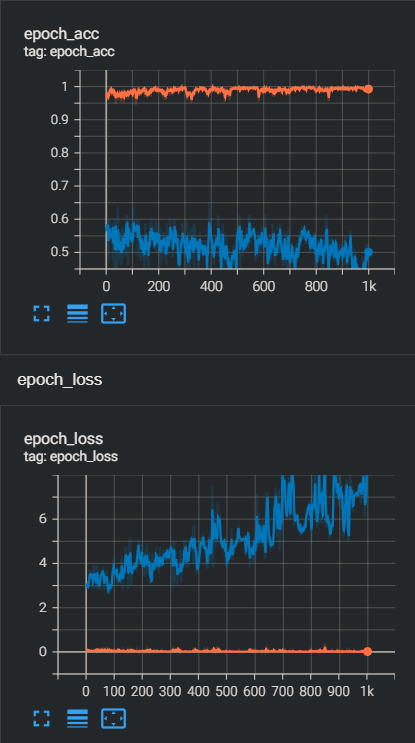

We are able achieve a peak validation accuracy of 61.25%! You might notice that validation loss is generally trending upwards, but this is nothing really out of the ordinary, the small model starts overfitting on the small dataset. Overall, not a bad result. Thanks for reading!